In [ ]:
!git clone https://github.com/Gabrysse/MLDL2024_project1.git
%cd MLDL2024_project1
!gdown "https://drive.google.com/uc?id=1ZX0UCXvJwqd2uBGCX7LI2n-DfMg3t74v" -O deeplabv2_pretrained.pth

In [ ]:
!pip install torch torchvision pytorch-lightning
!pip install  opencv-python tqdm albumentations
!pip install ptflops
!pip install -U fvcore


In [ ]:
!wget https://zenodo.org/record/5706578/files/Train.zip
!wget https://zenodo.org/record/5706578/files/Val.zip
!unzip Train.zip -d ./LoveDA
!unzip Val.zip -d ./LoveDA

In [4]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
import numpy as np

class LoveDADataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = sorted(os.listdir(os.path.join(root, "images_png")))
        self.masks = sorted(os.listdir(os.path.join(root, "masks_png")))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images_png", self.images[idx])
        mask_path = os.path.join(self.root, "masks_png", self.masks[idx])

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))

        if self.transform:
          augmented = self.transform(image=image, mask=mask)
          image = augmented["image"]
          mask = augmented["mask"]

        mask = np.array(mask, dtype=np.int64) - 1
        mask = np.clip(mask, 0, 7 - 1)

        return image, torch.tensor(mask.squeeze(), dtype=torch.long)


In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.Resize(384, 384),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2()
])

train_dataset = LoveDADataset(root="/content/MLDL2024_project1/LoveDA/Train/Rural", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True )

val_dataset = LoveDADataset(root="/content/MLDL2024_project1/LoveDA/Val/Rural", transform=transform)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
from models.deeplabv2.deeplabv2 import get_deeplab_v2
import torch
import gc

# Clear GPU memory
torch.cuda.empty_cache()
gc.collect()


# Initialize the DeepLabV2 model
NUM_CLASSES = 7
PRETRAIN_PATH = '/content/MLDL2024_project1/deeplabv2_pretrained.pth'

model = get_deeplab_v2(num_classes=NUM_CLASSES, pretrain=True, pretrain_model_path=PRETRAIN_PATH)

# Move the model to the appropriate device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(DEVICE)

Deeplab pretraining loading...


/content/MLDL2024_project1/models/deeplabv2/deeplabv2.py:180: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state_dict = torch.load(pretrain_model_path)


In [7]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)


In [8]:
import time
from ptflops import get_model_complexity_info
from torch import nn, optim
from torchmetrics import JaccardIndex
from fvcore.nn import FlopCountAnalysis, flop_count_table
import torch
from tqdm import tqdm

model.train()
for epoch in range(20):
    epoch_loss = 0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/20"):
        images, masks = images.cuda(), masks.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]

        # Print shape information for debugging
        if epoch == 0 and epoch_loss == 0:
            print(f"Output shape: {outputs.shape}")
            print(f"Mask shape: {masks.shape}")
            print(f"Unique values in masks: {torch.unique(masks)}")

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")


torch.save(model.state_dict(), "deeplabv2_loveda_rural.pth")
print("Model saved as deeplabv2_loveda_rural.pth")


# Function to compute mIoU
def jaccard(preds, targets, num_classes=7):
    intersection = torch.zeros(num_classes, device=preds.device)
    union = torch.zeros(num_classes, device=preds.device)

    for cls in range(num_classes):
        intersection[cls] += ((preds == cls) & (targets == cls)).sum()
        union[cls] += ((preds == cls) | (targets == cls)).sum()

    iou_per_class = intersection / union
    iou_per_class[union == 0] = float('nan')
    return torch.nanmean(iou_per_class).item()

# Validation loop
model.eval()
miou = 0

with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to('cuda'), masks.to('cuda')

        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        preds = torch.argmax(outputs, dim=1)

        miou += jaccard(preds, masks)

avg_miou = miou / len(val_loader)
print(f"Validation mIoU: {avg_miou:.4f}")

# Measure FLOPs and Parameters
height, width = 384, 384
dummy_input = torch.randn(1, 3, height, width).to('cuda')

flops = FlopCountAnalysis(model, dummy_input)
print(flop_count_table(flops))

# Measure latency and FPS
iterations = 100
latencies = []

for _ in range(iterations):
    image = torch.randn(1, 3, 512, 512).to('cuda')
    start_time = time.time()
    _ = model(image)
    latency = time.time() - start_time
    latencies.append(latency)

mean_latency = np.mean(latencies) * 1000  # ms
std_latency = np.std(latencies) * 1000  # ms
fps = 1 / np.mean(latencies)

print(f"Mean Latency: {mean_latency:.2f} ms")
print(f"Latency Std Dev: {std_latency:.2f} ms")
print(f"FPS: {fps:.2f}")

Epoch 1/20:   0%|          | 0/342 [00:00<?, ?it/s]

Output shape: torch.Size([4, 7, 384, 384])
Mask shape: torch.Size([4, 384, 384])
Unique values in masks: tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


Epoch 1/20: 100%|██████████| 342/342 [05:14<00:00,  1.09it/s]


Epoch 1, Loss: 1.9315


Epoch 2/20: 100%|██████████| 342/342 [05:15<00:00,  1.08it/s]


Epoch 2, Loss: 1.4070


Epoch 3/20: 100%|██████████| 342/342 [05:19<00:00,  1.07it/s]


Epoch 3, Loss: 1.2647


Epoch 4/20: 100%|██████████| 342/342 [05:22<00:00,  1.06it/s]


Epoch 4, Loss: 1.0569


Epoch 5/20: 100%|██████████| 342/342 [05:23<00:00,  1.06it/s]


Epoch 5, Loss: 0.9508


Epoch 6/20: 100%|██████████| 342/342 [05:24<00:00,  1.05it/s]


Epoch 6, Loss: 0.8672


Epoch 7/20: 100%|██████████| 342/342 [05:25<00:00,  1.05it/s]


Epoch 7, Loss: 0.8240


Epoch 8/20: 100%|██████████| 342/342 [05:25<00:00,  1.05it/s]


Epoch 8, Loss: 0.7547


Epoch 9/20: 100%|██████████| 342/342 [05:26<00:00,  1.05it/s]


Epoch 9, Loss: 0.7289


Epoch 10/20: 100%|██████████| 342/342 [05:26<00:00,  1.05it/s]


Epoch 10, Loss: 0.7003


Epoch 11/20: 100%|██████████| 342/342 [05:26<00:00,  1.05it/s]


Epoch 11, Loss: 0.6828


Epoch 12/20: 100%|██████████| 342/342 [05:26<00:00,  1.05it/s]


Epoch 12, Loss: 0.6659


Epoch 13/20: 100%|██████████| 342/342 [05:26<00:00,  1.05it/s]


Epoch 13, Loss: 0.6303


Epoch 14/20: 100%|██████████| 342/342 [05:28<00:00,  1.04it/s]


Epoch 14, Loss: 0.6086


Epoch 15/20: 100%|██████████| 342/342 [05:28<00:00,  1.04it/s]


Epoch 15, Loss: 0.5733


Epoch 16/20: 100%|██████████| 342/342 [05:27<00:00,  1.04it/s]


Epoch 16, Loss: 0.5449


Epoch 17/20: 100%|██████████| 342/342 [05:28<00:00,  1.04it/s]


Epoch 17, Loss: 0.5345


Epoch 18/20: 100%|██████████| 342/342 [05:29<00:00,  1.04it/s]


Epoch 18, Loss: 0.5113


Epoch 19/20: 100%|██████████| 342/342 [05:28<00:00,  1.04it/s]


Epoch 19, Loss: 0.4765


Epoch 20/20: 100%|██████████| 342/342 [05:29<00:00,  1.04it/s]


Epoch 20, Loss: 0.4613
Model saved as deeplabv2_loveda_rural.pth
Validation mIoU: 0.1975
| module                         | #parameters or shape   | #flops     |
|:-------------------------------|:-----------------------|:-----------|
| model                          | 43.016M                | 0.105T     |
|  conv1                         |  9.408K                |  0.347G    |
|   conv1.weight                 |   (64, 3, 7, 7)        |            |
|  bn1                           |  0.128K                |  4.719M    |
|   bn1.weight                   |   (64,)                |            |
|   bn1.bias                     |   (64,)                |            |
|  layer1                        |  0.216M                |  2.031G    |
|   layer1.0                     |   75.008K              |   0.706G   |
|    layer1.0.conv1              |    4.096K              |    38.539M |
|    layer1.0.bn1                |    0.128K              |    1.204M  |
|    layer1.0.conv2              | 

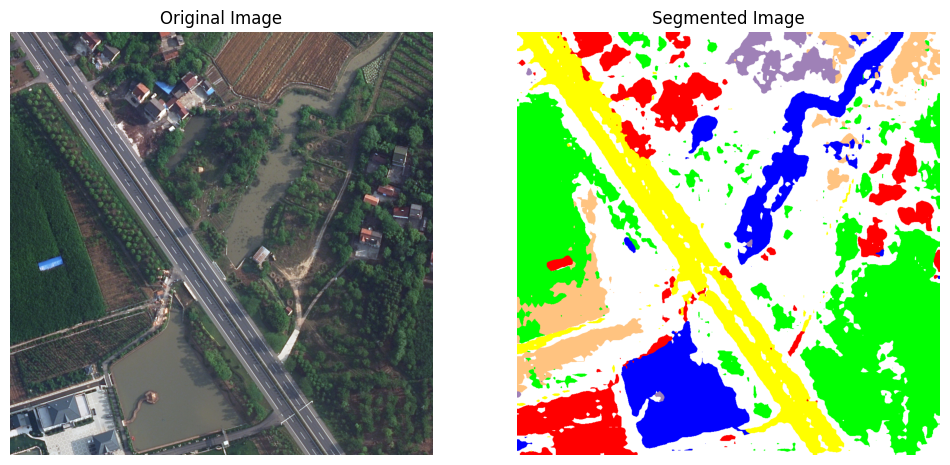

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from torchvision import transforms

# Define label colors (R, G, B) for each class
class_labels = ["background", "building", "road", "water", "barren", "forest", "agriculture"]
label_colors = {
    "background": (255, 255, 255),        # White
    "building": (255, 0, 0),             # Red
    "road": (255, 255, 0),               # Yellow
    "water": (0, 0, 255),                # Blue
    "barren": (159, 129, 183),           # Purple
    "forest": (0, 255, 0),               # Green
    "agriculture": (255, 195, 128)       # Peach
}

# Load a single image for segmentation
image_path = "/content/MLDL2024_project1/LoveDA/Test/Rural"
image_files = [f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f)) and not f.startswith('.')]
image_name = image_files[0]
image = Image.open(os.path.join(image_path, image_name)).convert('RGB')

# Preprocess the image (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_image = transform(image).unsqueeze(0).to(DEVICE)

# Perform inference with the model
model.eval()
with torch.no_grad():
    output = model(input_image)
    if isinstance(output, tuple):  # Handle tuple outputs
        output = output[0]
    preds = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

# Create a segmentation map
segmentation_map = np.zeros((preds.shape[0], preds.shape[1], 3), dtype=np.uint8)

for label_index, label_name in enumerate(class_labels):
    color = label_colors[label_name]
    segmentation_map[preds == label_index] = color

# Visualize the original image and segmentation map
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(segmentation_map)
plt.title("Segmented Image")
plt.axis("off")

plt.show()